In [2]:
# Hypothesis: smaller kernel sizes will lead to higher accuracies of classification in fined-tuned image classification
# We think this is likely due to the ability of the CNN to detect smaller features between relatively similar images of the same species
# Independent Variables: kernel size
# Constant Variables: number of layers, types of layers, input shape, epoches, hyperparamaters(depth,padding)
# Dependent Variables: Accuracy
# Limitations: we are foregoing pure accuracy for experimental reasons - we could get higher accuracy if we tried but we're keeping
# things constant for consistancy between models
# Currently only using Input, Convolutional, Relu, Pool, and FC/Dense layers. Can add Dense and Dropout if we have time
# Reference to www.cs231n.github.io/convolutional-networks

In [2]:
# 3. Import libraries and modules
import os, cv2, argparse
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import RandomState
np.random.seed(123)  # for reproducibility
import sys
import random

/home/cfu288/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def shuffle_data(arr1, arr2):
    seed = random.randint(0, 1000)
    ran = RandomState(seed)
    ran.shuffle(arr1)
    ran = RandomState(seed)
    ran.shuffle(arr2)

In [5]:
# INPUT
TRAIN_DIR = './training/'
TEST_DIR = './validation/'
EPOCHS = 10
HEIGHT = 150
WIDTH = 150

READING IN AND FORMATTING IMAGES


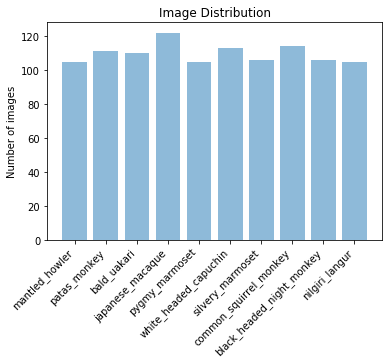

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,105,26
1,n1,erythrocebus_patas,patas_monkey,111,28
2,n2,cacajao_calvus,bald_uakari,110,27
3,n3,macaca_fuscata,japanese_macaque,122,30
4,n4,cebuella_pygmea,pygmy_marmoset,105,26
5,n5,cebus_capucinus,white_headed_capuchin,113,28
6,n6,mico_argentatus,silvery_marmoset,106,26
7,n7,saimiri_sciureus,common_squirrel_monkey,114,28
8,n8,aotus_nigriceps,black_headed_night_monkey,106,27
9,n9,trachypithecus_johnii,nilgiri_langur,105,26


In [42]:
# # Setup, Read in images, Preprocess images for training
TRAIN_IMG, TRAIN_CLS, TEST_IMG, TEST_CLS = ([] for i in range(4))
COLS = ['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images']
LABELS = pd.read_csv('./monkey_labels.txt', names=COLS, skiprows=1)
CLASSES = [x for x in range(0, len(LABELS))]

# read in all images
# resizing the images to 100x100 to make training faster
print("READING IN AND FORMATTING IMAGES")
# for x in range(0, len(LABELS)):
#     train_dir = TRAIN_DIR + LABELS.loc[x,'Label'].strip() + '/'
#     test_dir = TEST_DIR + LABELS.loc[x,'Label'].strip() + '/'
#     print(train_dir)
#     for file in os.listdir(train_dir):
#         if not file.endswith('jpg'):
#             print("empty file")
#             continue
#         img = cv2.imread(train_dir + file)
#         if img is not None:
#             img = cv2.resize(img, (150, 150))
#             TRAIN_IMG.append(img)
#             TRAIN_CLS.append(x)
#     for file in os.listdir(test_dir):
#         img = cv2.imread(test_dir + file)
#         if img is not None:
#             img = cv2.resize(img, (150, 150))
#             TEST_IMG.append(img)
#             TEST_CLS.append(x)
# print("DONE")

# print(len(TRAIN_IMG))
titles = LABELS.iloc[:,2].tolist()
for x in range(len(titles)):
    titles[x] = titles[x].strip()
y_pos = np.arange(len(titles))
vals = LABELS.iloc[:,3].tolist()

plt.bar(y_pos, vals, align='center', alpha=0.5)
plt.xticks(y_pos, titles, rotation=45, ha='right')
plt.ylabel("Number of images")
plt.title("Image Distribution")
plt.show()
LABELS

In [29]:
# convert to numpy arrays
# TRAIN_IMG = np.array(TRAIN_IMG)
TEST_IMG = np.array(TEST_IMG)
# TRAIN_CLS = np.array(TRAIN_CLS)
TEST_CLS = np.array(TEST_CLS)

# print(TRAIN_IMG.shape)
# plt.imshow(TRAIN_IMG[0])

# # Preprocess images
# # Reshape them to theanos format (channels, hight, width) # changed to tensorflow
# # Convert to 0-255 to value in [0-1]
# TRAIN_IMG = TRAIN_IMG.reshape(TRAIN_IMG.shape[0], 150, 150, 3)
TEST_IMG = TEST_IMG.reshape(TEST_IMG.shape[0], 150, 150, 3)
# TRAIN_IMG = TRAIN_IMG.astype('float32')
TEST_IMG = TEST_IMG.astype('float32')
# TRAIN_IMG /= 255
TEST_IMG /= 255

# # Reshape class labels
# TRAIN_CLS = np_utils.to_categorical(TRAIN_CLS, 10)
TEST_CLS = np_utils.to_categorical(TEST_CLS, 10)

# # Shuffle the data
# shuffle_data(TRAIN_IMG, TRAIN_CLS)
# shuffle_data(TEST_IMG, TEST_CLS)

In [8]:
TRAIN_DATAGEN = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   rotation_range=25, 
                                   horizontal_flip=True, 
                                   zoom_range=0.1, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   fill_mode='nearest'
                                  )

TEST_DATAGEN = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

TRAIN_GENERATOR = TRAIN_DATAGEN.flow_from_directory(
        TRAIN_DIR,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')
print(TRAIN_GENERATOR.image_shape)

TEST_GENERATOR = TEST_DATAGEN.flow_from_directory(
        TEST_DIR,  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')

print(TEST_GENERATOR.class_indices)

Found 1097 images belonging to 10 classes.
(150, 150, 3)
Found 272 images belonging to 10 classes.
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}


In [16]:
# Print some of the input for display
#plt.imshow(TRAIN_IMG[0])

In [43]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

base_model.summary()
# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

# Add custom model at the end
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=5*5*2048))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Print the layers in the model
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Number of samples processed per epoch is steps_per_epoch * batch_size
history = model.fit_generator(TRAIN_GENERATOR, steps_per_epoch=34, epochs=40, verbose=1, shuffle=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [22]:
#model = load_model('models/xception-150x150-10e.h5')

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#history = model.fit(TRAIN_IMG, TRAIN_CLS, batch_size=32, epochs=EPOCHS+5, 
                    #initial_epoch=EPOCHS, validation_split=0.1, verbose=1, shuffle=True)
    


history2 = model.fit_generator(TRAIN_GENERATOR, steps_per_epoch=34, epochs=50, initial_epoch=40, verbose=1, shuffle=True)

Epoch 41/50
34/34 [==============================] - 104s 3s/step - loss: 0.7274 - acc: 0.7632
Epoch 42/50
34/34 [==============================] - 106s 3s/step - loss: 0.7273 - acc: 0.7660
Epoch 43/50
34/34 [==============================] - 104s 3s/step - loss: 0.8148 - acc: 0.7458
Epoch 44/50
34/34 [==============================] - 104s 3s/step - loss: 0.7477 - acc: 0.7618
Epoch 45/50
34/34 [==============================] - 104s 3s/step - loss: 0.7564 - acc: 0.7448
Epoch 46/50
34/34 [==============================] - 104s 3s/step - loss: 0.7049 - acc: 0.7682
Epoch 47/50
34/34 [==============================] - 104s 3s/step - loss: 0.7834 - acc: 0.7540
Epoch 48/50
34/34 [==============================] - 104s 3s/step - loss: 0.7467 - acc: 0.7531
Epoch 49/50
34/34 [==============================] - 104s 3s/step - loss: 0.7055 - acc: 0.7591
Epoch 50/50
34/34 [==============================] - 104s 3s/step - loss: 0.7387 - acc: 0.7710


In [29]:
# Save the model
print("SAVE MODEL")
model.save('models/xception-150x150-40e-generator.h5')
print(history.history.keys())

SAVE MODEL
dict_keys(['loss', 'acc'])


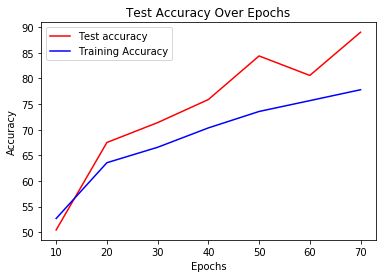

In [11]:
# Print a plot of loss and accuracy over epochs
test_acc = [50.45, 67.50, 71.3746, 75.874, 84.378, 80.575, 88.999284328]
train_acc = [52.676, 63.555, 66.56565, 70.3434, 73.54957, 75.66, 77.78745]
#val_acc = history.history['val_acc']
#loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = [10, 20, 30, 40, 50, 60, 70]

plt.title('Test Accuracy Over Epochs')
plt.plot(epochs, test_acc, 'red', label='Test accuracy')
plt.plot(epochs, train_acc, 'blue', label='Training Accuracy')
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

# plt.figure()
# plt.title('Training and validation loss')
# plt.plot(epochs, loss, 'red', label='Training loss')
# plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()



In [3]:
#model = load_model('test_model.h5')

# Evaluate the model on the validation data
loss, acc = model.evaluate_generator(TEST_GENERATOR, 272/32)
print("Loss: ", loss, " Accuracy: ", acc)

loss, acc = model.evaluate(TEST_IMG, TEST_CLS, verbose=1)
print("Loss: ", loss, " Accuracy: ", acc)

preds = model.predict_generator(TEST_GENERATOR, 272/32)
preds

NameError: name 'model' is not defined

In [ ]:
# Predict images
# TODO - Print mispredicted images, the label it predicted, and the correct label
'''
for i in range(len(TEST_IMG)):
    img = TEST_IMG[i]
    cls = TEST_CLS[i]
    img = np.array([img])
    prediction = model.predict(img, verbose=1, steps=1)
    print
    print "Class: ", cls
    print "Prediction: ", prediction[0]
    max_index = np.argmax(prediction[0])
    print "Predicted Class index: ", max_index
    print "Prediction Correct: ", True if cls[max_index] == 1. else False
'''